# CIFAR-10 Image Classifier

### Waterloo Aerial Robotics Group Computer Vision Onboarding

Mckale Chung

This is a image classifying model with a 70% accuracy rate, trained on the CIFAR - 10 data set. 

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix
import torch
from torch import nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision
from torch.utils.data import random_split
import torch.nn.functional as F



I first defined a composition of the pytorch built-in ToTensor and Normalize function. 

I then loaded the training and testing data sets from PyTorch, and created data loaders for these sets. 

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

training_data_raw = CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#Taking 2000 images for validation
val_size = 2000

#The rest of the images are for standard training
train_size = len(training_data_raw) - val_size


#splitting the raw 50000 training data into a training and validation data set
training_data, val_data = random_split(training_data_raw, [train_size, val_size])


#confirming a proper split
print(f"Length of Training Data : {len(training_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#Making loaders for all data

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)





Files already downloaded and verified
Length of Training Data : 48000
Length of Validation Data : 2000


To confirm that the data loaded in, I first created a seperate dictionary with the 10 distinct classes. I can now reference the index of these to get a label name. 

In [6]:
classes = training_data_raw.classes
print(classes)
print(type(training_data_raw))


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
<class 'torchvision.datasets.cifar.CIFAR10'>


### Showing the Data

The following code shows a set of 8 images, and their corresponding labels


tensor([8, 2, 2, 5, 8, 0, 1, 7])


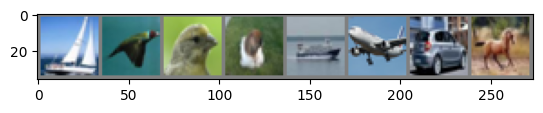

ship
bird
bird
dog
ship
airplane
automobile
horse


In [8]:
def imshow(img):
    #unnormalizing the images
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(labels)

#showing the images and the labels in the same order
imshow(torchvision.utils.make_grid(images))
for img_num in range(batch_size):
    print(classes[labels[img_num]])

plt.show()

In [10]:
class Net(nn.Module):

    
    def __init__(self):
        super().__init__()
        
        #first convolution layer takes in a 3 channel image
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [11]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [69]:
#using a cross entropy loss function and setting an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [70]:
#Setting dicts for graphing 
#Iterating through 10 epochs
epochs = np.arange(1, 11)
losses = {}
val_losses = {}


for epoch in epochs:  # loop over the dataset multiple times

    running_loss = 0.0
    running_val_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        #get inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        #forward and backward function calls
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        #optimizer parameter update
        optimizer.step()

        # print statistics
        running_loss += loss.item()

  
    
    net.eval()
    
    
    #same as the training procedure, on validation set
    for j,v_data in enumerate(val_loader, 0):
        v_inputs, v_labels = v_data
        optimizer.zero_grad()
        outputs = net(inputs)
        v_loss = criterion(outputs, labels)
        v_loss.backward()
        optimizer.step()
        running_val_loss += v_loss.item()
    
    print(f'[{epoch + 1}] loss: {running_loss / 2000:.3f} val_loss: {running_val_loss / 2000:.3f}')
    
    losses[epoch] = running_loss / 2000
    val_losses[epoch] = running_val_loss / 2000
    
    running_loss = 0.0
    running_val_loss = 0.0

print('Finished Training')

[2] loss: 5.506 val_loss: 0.165
[3] loss: 4.291 val_loss: 0.129
[4] loss: 3.886 val_loss: 0.090
[5] loss: 3.599 val_loss: 0.142
[6] loss: 3.385 val_loss: 0.105
[7] loss: 3.180 val_loss: 0.098
[8] loss: 3.012 val_loss: 0.189
[9] loss: 2.853 val_loss: 0.107
[10] loss: 2.717 val_loss: 0.086
[11] loss: 2.607 val_loss: 0.043
Finished Training


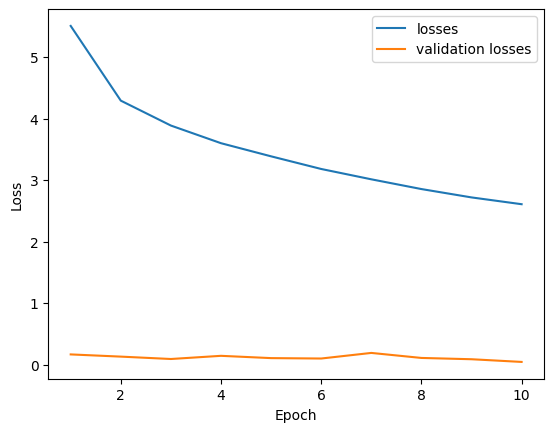

In [71]:
#plotting the loss dictionary values against the validation loss dictionary values

plt.plot(epochs, losses.values(), label = "losses")
plt.plot(epochs, val_losses.values(), label = "validation losses")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Display the plot
plt.show()

In [72]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

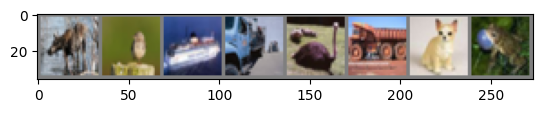

Actual:  deer          Predicted:  dog  
Actual:  bird          Predicted:  bird 
Actual:  ship          Predicted:  ship 
Actual:  truck         Predicted:  truck
Actual:  bird          Predicted:  cat  
Actual:  truck         Predicted:  horse
Actual:  dog           Predicted:  dog  
Actual:  frog          Predicted:  frog 


In [76]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

#outputting the actual and predicted classes of each image
for pred_img in range(8):
    print("Actual: ", ''.join(f'{classes[labels[pred_img]]:10s}'),        
          "   Predicted: ",''.join(f'{classes[predicted[pred_img]]:5s}'))



Accuracy of the network on the 10000 test images: 70 %


<AxesSubplot:title={'center':'Heatmap of model accuracy'}>

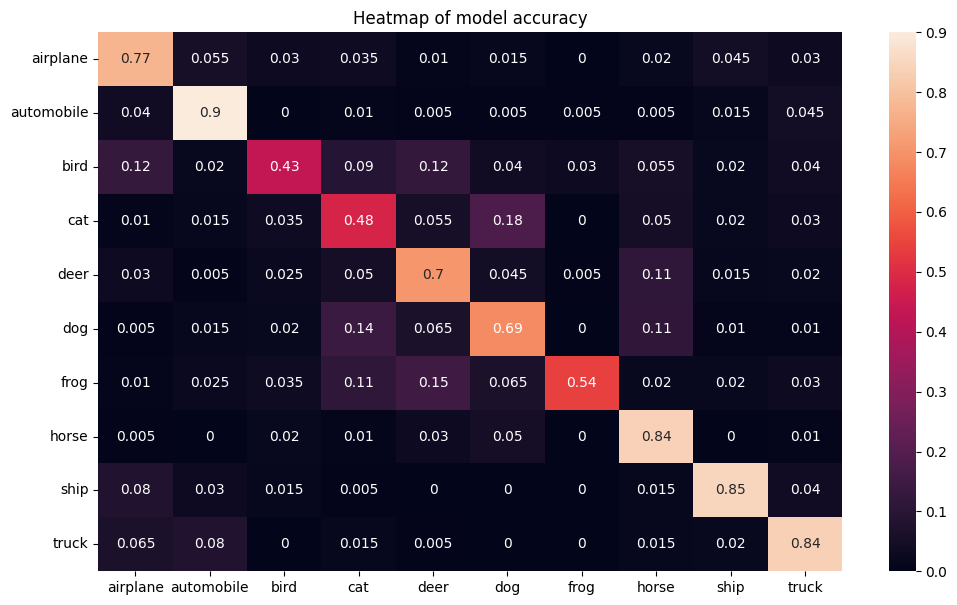

In [77]:
correct = 0
total = 0
y_pred = []
y_true = []


with torch.no_grad():
    for data in test_loader:
        images, labels = data
        
        # calculate outputs by running images through the network
        outputs = net(images)
        outputs_heat = net(images)
        
        #counting the amount of images seen and the amount that is correct and iterating
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        
        outputs_heat = (torch.max(torch.exp(outputs_heat), 1)[1]).data.cpu().numpy()
        y_pred.extend(outputs_heat) # predicted values
        
        labels_heat = labels.data.cpu().numpy()
        y_true.extend(labels_heat) # actual values

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


#setting a confusion matrix for a heatmap
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title("Heatmap of model accuracy")
sns.heatmap(df_cm, annot=True)